In [1]:
import numpy as np
import matplotlib.pyplot as plt

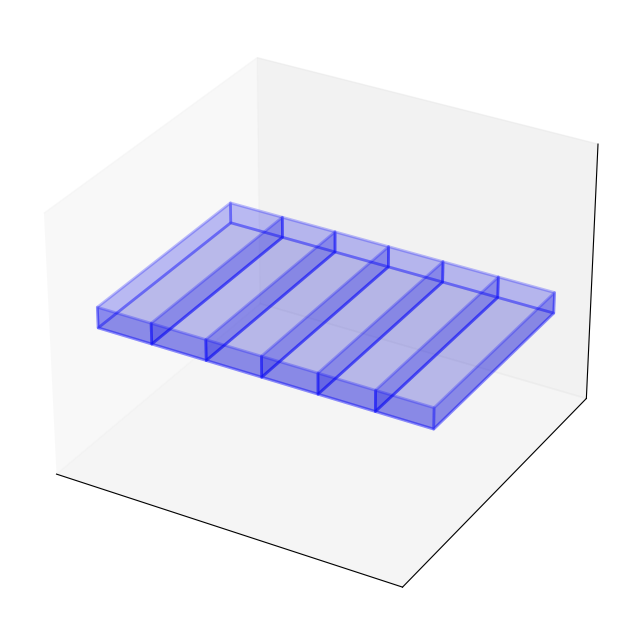

In [143]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

d_model = 8
d_hidden = 2*d_model
B = 64
L = 6

L_by_hidden_ax = 0
B_ax = 1
d_model_ax = 2

def plot_face(ax, vals1, vals2, depth, ax1, ax2):
    ax3 = 3 - ax1 - ax2
    val1, val2 = np.meshgrid(vals1, vals2)
    val3 = np.full_like(val1, depth)
    arg = np.array([val1, val2, val3])[[ax1, ax2, ax3]]
    ax.plot_surface(*arg,
                    alpha=0.25, color='b', edgecolor='b', linewidth=2)

for l in range(L+1):
    plot_face(ax, (0, d_model), (0, B), l*d_hidden, d_model_ax, B_ax)
    if l == L:
        break
    plot_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, B), 0, L_by_hidden_ax, B_ax)
    plot_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, d_model), 0, L_by_hidden_ax, d_model_ax)
    plot_face(ax, (l*d_hidden, (l+1)*d_hidden), (0, d_model), B, L_by_hidden_ax, d_model_ax)

width = L*d_hidden
ax.set_xlim3d(0, width)
ax.set_zlim3d((d_model - width)/2, (d_model + width)/2)
ax.set_ylim3d((B - width)/2, (B + width)/2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
plt.show()
